# Calculating Metrics to Evaluate VS performance

This notebook applies the different metrics reviewed in the previous notebook to the VS scoring results and predictions given by different docking tools.

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
sys.path.append(r'..')

In [2]:
from modules.plotting_metrics import PlotMetric

## Loading Docking Results
> ### Docking Score

In [3]:
prot_name = 'cdk2'
patho_to_json_file = glob.glob((os.path.join('..', 'data', 
                        F'TABLA_MTDATA_{prot_name.upper()}_*_crys_LIGS_INFO_LABELS_AUC_docking_DUD.json')))[0]
df_cdk2_labels = pd.read_json(patho_to_json_file)

In [4]:
# 
docking_tools = ['AD4_LE', 'AD4_LE', 'VINA', 'VINARDO']
metrics = []

# CSAR DockingScores
csar_dkScores = {dk_tool: pd.read_csv(F'../data/vs_docking_crys_ensemble_{dk_tool}.csv', index_col=0)
                 for dk_tool in docking_tools}


In [5]:
pdb_ids = csar_dkScores['VINA'].drop(['ActiveInactive'], axis = 1).columns

for pdb_id in pdb_ids:

SyntaxError: unexpected EOF while parsing (<ipython-input-5-aff72826f606>, line 3)

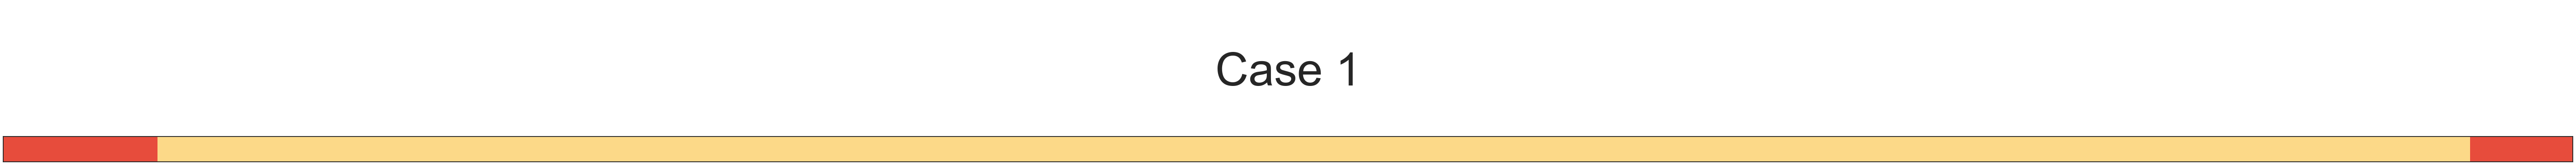

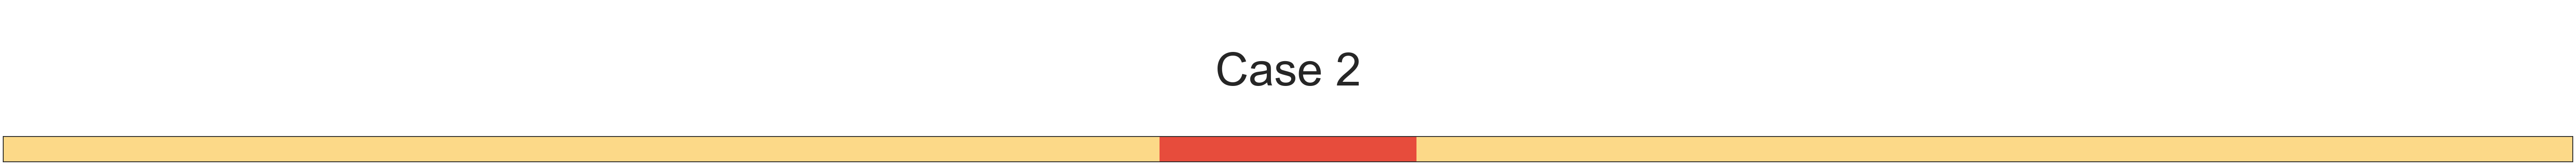

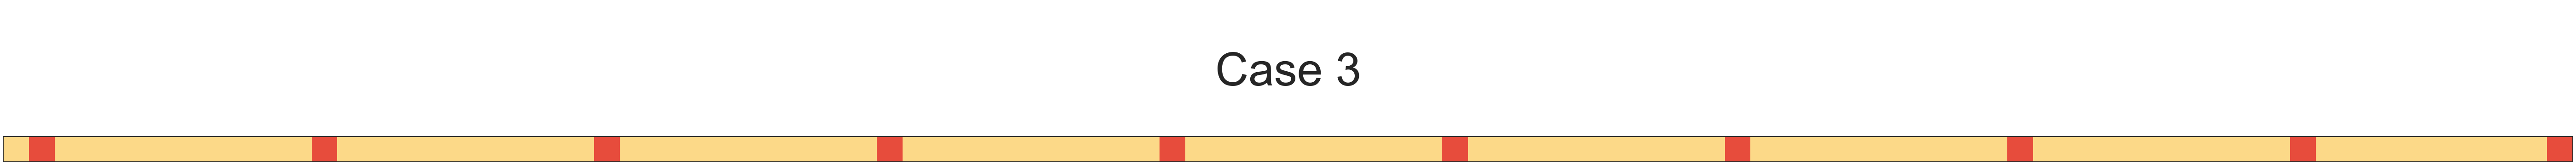

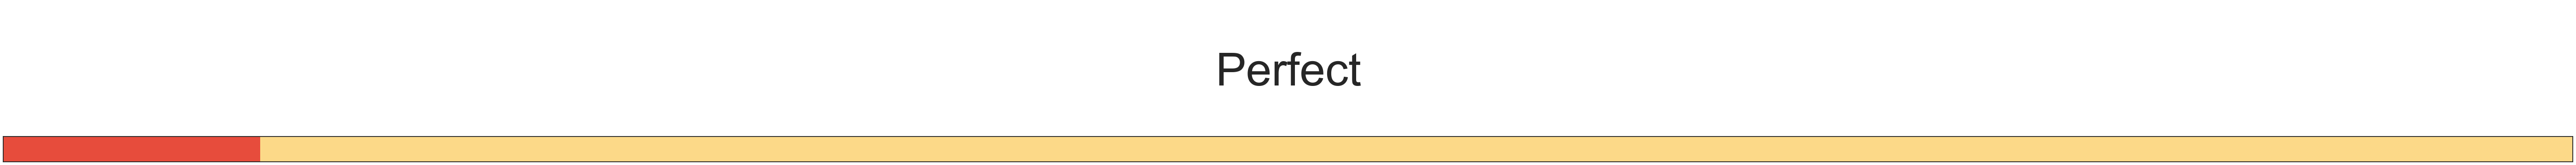

In [8]:
# Generamos los tres casos de CSAR
from truchon_2006_3_ranking_cases import get_three_ranking_cases
# Creamos el arreglo de valores verdaderos:
y_true_csar = np.array([1 if i < 10 else 0 for i in range(100)])
csar_cases_preds = get_three_ranking_cases(y_true_csar, include_optimal = True)
csar_cases = PlotMetric(y_true = y_true_csar, y_pred_dict = csar_cases_preds)
csar_cases.plot_actives_distribution()

In [ ]:
csar_cases.